# Deep Learning Experiment - Pixel Classification

## Abstract

We take a naive approach to pixel classification (image segmentation) by machine learning with artificial neural networks. The focus here is on exploring practical issues like the preparation of data, python [1] programming and the use of the keras library [2]. The theroretical background of machine learning and deep learning is treated elsewhere [3].

Since we know that vectors of measurements can be classified by neural networks, we attempt to do image segmentation in the same way. We consider the NxN environment of each pixel of an image as a feature vector and classify each pixel as either belonging to the background or to an object of interest. Given a number of input images and corresponding ground truth images we extract the training and validation data. We build a neural network using keras, train it with the extracted training data and vaildate it using the extracted validation data. The created classidier is then applied on input images to create a segmentation mask and a probability map. 

The python programming constructs are explained along the process.

## Setup for Colab

When running in google colab, we need to install tifffile and update the keras version. We also need to download the dataset. 

In [1]:
import os
if  not os.path.isdir('./training'):
  !pip install tifffile
  !pip install -U keras
  !pip install mpld3
  !cd /content/ && git clone https://github.com/MontpellierRessourcesImagerie/DL_EXP_PC.git && cp -r DL_EXP_PC/data . && cp -r DL_EXP_PC/training .

## Reading in and preparing the training data

For simplicity we will use one image to construct the input data for now. We will generalize this to multiple images later. We have one input image and a correcponding ground-truth image as our training input.

As the input of the neural network we need a matrix X containing the input data and a vector y containing the classification for each row in the input matrix. We will construct X and y from the input dataset by first looking at the ground truth images and randomly choosing a number S of foreground samples and a number S of background samples. 

We set the paths to the input image and the ground-truth image, the patch size N and the number of samples S of foreground and background values.

In [2]:
inputPath = './training/spots.tif'
gtPath = './training/spots-gt.tif'
N = 3
S = 20000

We read in the input and the ground-truth image as numpy matrices.

In [3]:
import tifffile as tiff
gtImage = tiff.imread(gtPath)
inputImage = tiff.imread(inputPath) / 255
print(inputImage.shape)

(1830, 1980)


We filter out the background samples and the object samples from the ground-truth image.

In [4]:
import numpy as np
foregroundY, foregroundX = gtImage.nonzero()
foreground = list(zip(foregroundY, foregroundX))
backgroundY, backgroundX = (gtImage==0).nonzero()
background = list(zip(backgroundY, backgroundX))
print(background[0:10], "nr.:", len(background))
print(foreground[0:10], "nr.:", len(foreground))

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9)] nr.: 3412479
[(36, 1765), (36, 1766), (36, 1767), (36, 1768), (36, 1769), (37, 1764), (37, 1765), (37, 1766), (37, 1767), (37, 1768)] nr.: 210921


We select S randomly choosen coordinates from the foreground and S randomly choosen coordinates from the background. We do not take coordinates close to the borders for which the whole neighborhood is not inside of the image.

In [5]:
from random import randint
height, width = gtImage.shape
def getNCoordinateSamplesFrom(n, aList, minX, maxX, minY, maxY):
    samples = []
    for _ in range(n):
        r = randint(0,len(aList)-1)
        coords = aList[r]
        while coords[0]<=minY or coords[0]>=maxY or coords[1]<=minX or coords[1]>=maxX:    
            r = randint(0,len(foreground)-1)
            coords = foreground[r]
        samples.append(coords)
    return samples
FS = getNCoordinateSamplesFrom(S, foreground, N//2, width-N//2, N//2, height-N//2)
BS = getNCoordinateSamplesFrom(S, background, N//2, width-N//2, N//2, height-N//2)
print(FS[0:10])
print(BS[0:10])

[(1423, 1499), (363, 224), (1655, 424), (1077, 798), (958, 1661), (1727, 72), (1666, 783), (160, 878), (1007, 622), (1709, 793)]
[(971, 650), (453, 1714), (1713, 797), (173, 473), (567, 308), (798, 273), (647, 942), (1372, 946), (922, 577), (1121, 80)]


We create X and y by using the data at the sampled positions in the input image. Since we have separate lists of foreground and background samples, we know to which class each sample must be assigned.

In [6]:
def addSamplesToTrainingData(n, image, samples, X, y, target):
    start = -n//2 + 1
    stop = -start + 1
    for ys, xs in samples:
        vector = []
        for i in range(start, stop):
            for j in range(start, stop):
                vector.append(image[ys+i,xs+j])
        X.append(vector)
        y.append(target)
    return X, y
X = []
y = []
addSamplesToTrainingData(N, inputImage, FS, X, y, 1)
addSamplesToTrainingData(N, inputImage, BS, X, y, 0)
X = np.array(X)
y = np.array(y)
print("foreground samples\n", X[0:5], y[0:5])
print("background samples\n", X[S:S+5], y[S:S+5])

foreground samples
 [[0.47058824 0.51372549 0.56078431 0.51764706 0.55294118 0.53333333
  0.51764706 0.5254902  0.55294118]
 [0.35294118 0.39607843 0.41176471 0.4        0.37647059 0.36078431
  0.38039216 0.37254902 0.34901961]
 [0.4        0.42352941 0.43137255 0.4        0.41568627 0.43137255
  0.45098039 0.36470588 0.36078431]
 [0.48235294 0.4627451  0.47843137 0.45882353 0.48627451 0.47058824
  0.50588235 0.48627451 0.46666667]
 [0.45490196 0.4745098  0.46666667 0.45490196 0.4745098  0.47843137
  0.41176471 0.42745098 0.45490196]] [1 1 1 1 1]
background samples
 [[0.29411765 0.30980392 0.29019608 0.29411765 0.29803922 0.30980392
  0.31372549 0.30980392 0.31372549]
 [0.31764706 0.32156863 0.32941176 0.31764706 0.30980392 0.3372549
  0.32156863 0.31372549 0.30588235]
 [0.41568627 0.36470588 0.40392157 0.33333333 0.39215686 0.38431373
  0.38431373 0.34509804 0.35294118]
 [0.29411765 0.29411765 0.29803922 0.29019608 0.28627451 0.32941176
  0.29803922 0.29411765 0.28235294]
 [0.31764706

The way we created X and y, we have S foreground samples followed by S background samples. This might not be ideal. The training will be done in mini-batches. The data will be shuffled automatically in the training before the mini-batches are created. However for validation a fraction of the data is taken from the end of the data before the shuffling is done. We therefore shuffle the data now.

In [7]:
seed = np.random.randint(0, 2**(32 - 1) - 1) 
rstate = np.random.RandomState(seed)
rstate.shuffle(X)
rstate = np.random.RandomState(seed)
rstate.shuffle(y)
print("first 5 of mixed samples\n", X[0:5], y[0:5])
print("last 5 of mixed samples\n", X[S:S+5], y[S:S+5])

first 5 of mixed samples
 [[0.49019608 0.50196078 0.43921569 0.47058824 0.52941176 0.48235294
  0.51372549 0.50980392 0.49803922]
 [0.44313725 0.45098039 0.43137255 0.45490196 0.44705882 0.4745098
  0.4745098  0.45882353 0.44705882]
 [0.29803922 0.30588235 0.28627451 0.30980392 0.28627451 0.28627451
  0.31372549 0.32156863 0.31764706]
 [0.32941176 0.30980392 0.31764706 0.28627451 0.27843137 0.30196078
  0.32156863 0.30980392 0.29411765]
 [0.43921569 0.45882353 0.43529412 0.43921569 0.39215686 0.44313725
  0.41960784 0.46666667 0.45490196]] [1 1 0 0 1]
last 5 of mixed samples
 [[0.39215686 0.43137255 0.43529412 0.41568627 0.38823529 0.38823529
  0.35686275 0.40784314 0.40392157]
 [0.40784314 0.37254902 0.40392157 0.40784314 0.41176471 0.40392157
  0.47058824 0.41176471 0.40784314]
 [0.31372549 0.34117647 0.34901961 0.32156863 0.3254902  0.3254902
  0.31372549 0.3254902  0.34509804]
 [0.43529412 0.45490196 0.4745098  0.46666667 0.45098039 0.4745098
  0.45098039 0.50196078 0.48235294]
 [0

## Creating a network using keras

As a first approach we create a simple, densly connected network with 4 layers inspired by [[4]](https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/). We visualize the network architecture.

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 80        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


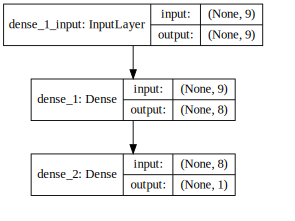

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from IPython.display import SVG
from keras.utils import model_to_dot

model = Sequential()
model.add(Dense(N*N-1, input_dim=(N*N), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

## Training the network

We now run the training of the network and calculate and display the trainig loss and accuracy. We also use one fouth of the data for validation and calculate the validation accuracy and loss.

In [9]:
%%time
history = model.fit(X, y, validation_split=0.25, epochs=25, batch_size=128, verbose=0)
print("Loss: ", history.history['val_loss'][-1], "Accuracy: ", history.history['val_accuracy'][-1])

Loss:  0.045568334621191024 Accuracy:  0.9869999885559082
CPU times: user 7.39 s, sys: 578 ms, total: 7.96 s
Wall time: 4.96 s


We visualize the training accuracy and loss history.

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt, mpld3
def createSubplot(x, dataSeries, dataLabels, title, xLabel, yLabel, legendLoc, position):
    plt.subplot(position)
    plt.title(title)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    for y, label in zip(dataSeries, dataLabels):
        plt.plot(x, y, label=label)
    plt.legend(loc=legendLoc)
xValues = np.arange(1., len(history.history['loss'])+1, 1)
plt.rcParams['xtick.major.pad']='16'
plt.rcParams['ytick.major.pad']='16'
plt.rcParams["figure.figsize"] = (15,5)
createSubplot(xValues, [history.history['accuracy'], history.history['val_accuracy']], 
              ["Training", "Validation"], "Model accuracy", "Epoch", "Accuracy",  "lower right", 121)
createSubplot(xValues, [history.history['loss'], history.history['val_loss']], 
              ["Training", "Validation"], "Model loss", "Epoch", "Loss", "upper right", 122)
plt.tight_layout(pad=3.0)
mpld3.display()

## Applying the model on images

We can now use the model to make predictions for the intensity vector of the neighborhood of a pixel.

In [11]:
prediction = model.predict(np.array([[128/255]*N*N]))
print(prediction)
classPrediction = model.predict_classes(np.array([[128/255]*N*N]))
print(classPrediction)

[[0.99993336]]
[[1]]


We will now use the model to segment images. We need to feed the neighborhood of all pixels to the classifier and create an output mask and a probability map from the result of the classification.

We set the path to the folder containing the input images. We will read each image in the folder, do the segmentation and save the result images.

Here is how it conceptually works. A loop iterates over the pixel in the input image. For each pixel a feature vector is created and classified from the intensities values in its neighborhood. It works but is very slow. We will therefore rather use an optimized version, that first creates a list of all feature vectors, passes them to the classification and then creates the mask and probability map from the results.

We first define a function that creates a list of feature vectors from an image. Each vector represents the intensities in the neighborhood of a pixel in the image. 

In [15]:
def getFeatureVectorsFromImage(image, n, reportInterval):    
    neighborsRange = range((-n//2)+1, (n//2)+1)
    height, width = image.shape
    neighborhood = np.zeros(n*n)
    neighborhoods = np.zeros((image.shape[0]*image.shape[1], n*n), dtype=float)
    vc = 0
    print("Extracting the feature vectors.")
    for y in range(0, height):
        if y%reportInterval == 0:
            print("\rRow: " + str(y), end="")
        for x in range(0, width):
            nc = 0
            for i in neighborsRange:
                for j in neighborsRange:
                    ic = i
                    jc = j
                    if x+i < 0 or x+i>=width:
                        ic = -1 * i
                    if y+j < 0 or y+j>=height:
                        jc = -1 * j    
                    neighborhood[nc] = image[y+jc,x+ic]
                    nc = nc + 1
            neighborhoods[vc]=neighborhood
            vc = vc + 1
    print("", end="\n")
    return neighborhoods

Now we create an output folder as a subfolder of the input folder and get a list of the images in the input folder.

In [16]:
import os
path = './data'
out = os.path.join(path, 'out')
if not os.path.isdir(out):
    os.mkdir(out)
files = os.listdir(path)
imagePaths = [os.path.join(path, f)  for f in files if not os.path.isdir(os.path.join(path, f))]
imagePaths.sort()
print(imagePaths)
!ls ./data

['./data/spots01.tif', './data/spots02.tif']
gt  out  spots01.tif  spots02.tif


For the result images pMap and mask we start with 1D arrays of size $width \times height$. We fill the linear arrays with the classification results and then reshape them to 2D-images.

In [17]:
%%time
import tifffile as tiff
for imagePath in imagePaths:   
    print("Processing image " + imagePath)
    image = tiff.imread(imagePath) / 255
    neighborhoods = getFeatureVectorsFromImage(image, N, 10)

    print("Applying the classifier.")
    pMap = model.predict(neighborhoods).flatten()
    mask = (np.round(pMap)*255).reshape(image.shape).astype(np.uint8)  
    pMap = (pMap * 255).reshape(image.shape).astype(np.uint8)
    
    print("Writing the output images.")
    outFileName = os.path.basename(imagePath)
    outFileName = os.path.splitext(outFileName)[0]
    outPath = os.path.join(out,outFileName + "-pMap.tif" )
    tiff.imwrite(outPath, pMap, imagej=True)
    outPath = os.path.join(out,outFileName + "-mask.tif" )
    tiff.imwrite(outPath, mask, imagej=True)
print("Done!")

Processing image ./data/spots01.tif
Extracting the feature vectors.
Row: 1820
Applying the classifier.
Writing the output images.
Processing image ./data/spots02.tif
Extracting the feature vectors.
Row: 1820
Applying the classifier.
Writing the output images.
Done!
CPU times: user 1min 18s, sys: 3.45 s, total: 1min 21s
Wall time: 1min 7s


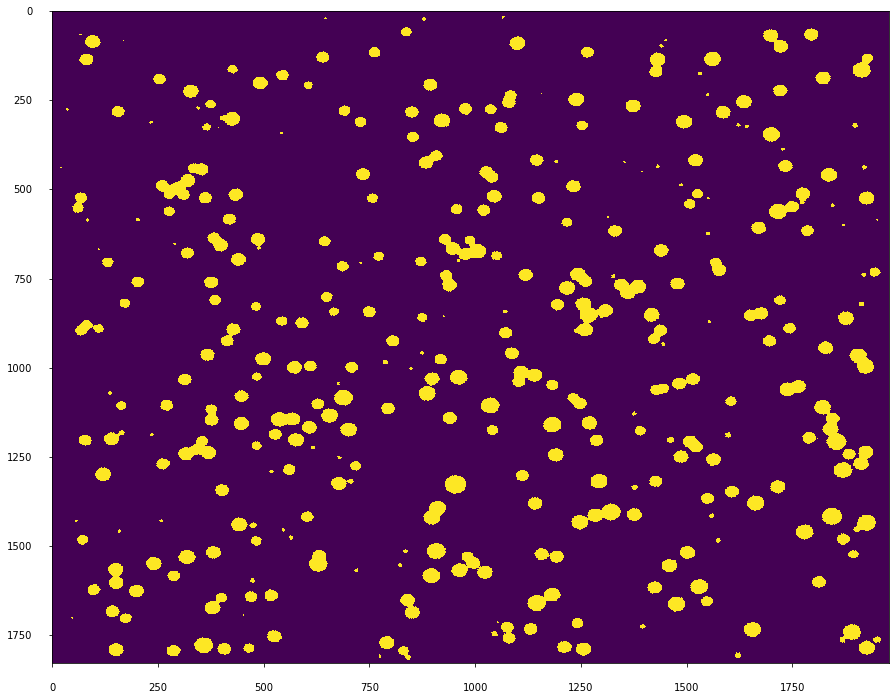

In [18]:
from matplotlib import pyplot as plt
plt.figure(figsize = (15,12))
plt.imshow(mask, interpolation='nearest', aspect="auto")
plt.show()

In [14]:
model.get_weights()

[array([[-0.10027412,  0.24947888, -0.2141105 , -0.0042963 , -0.6876477 ,
          1.0647981 ,  0.79249066,  0.31624848],
        [-0.261808  ,  0.11034656, -0.3476799 , -0.12323102, -0.4462426 ,
          0.65622467,  0.28279844,  0.8410371 ],
        [-0.10062718, -0.35625634, -0.17707768,  0.02133632, -0.33283406,
          0.9915828 ,  0.3000889 ,  0.87376547],
        [-0.70565605,  0.14563847,  0.28225076, -0.5665982 , -0.06473186,
          0.6367087 ,  1.1338865 ,  0.6653829 ],
        [-0.51850814, -0.31873006, -0.57809675, -0.12006801, -0.8928453 ,
          0.9808985 ,  0.4428513 ,  1.1218145 ],
        [-0.3898023 , -0.1355547 ,  0.50832784,  0.12309319, -0.5325432 ,
          0.2711881 ,  0.8150395 ,  1.0505173 ],
        [-0.49858722, -0.29766494,  0.370215  , -0.4011116 , -0.5788222 ,
          0.76388305,  0.36969602,  0.6289859 ],
        [-0.06321262,  0.2861836 , -0.51202244,  0.1633696 , -1.0685657 ,
          0.39110044,  0.8943148 ,  0.6424107 ],
        [-0.1682

We can save the model to a file and load it somewhere else to use it. Since the model can be big (which is not the case here) it is saved as a .h5 file.

In [19]:
model.save('simple-pixel-seg.h5')

To load it somewhere else use the load_model function from the module models of keras.

In [21]:
from keras.models import load_model
model2 = load_model('simple-pixel-seg.h5')
print(model2.summary())
model2.get_weights()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 80        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
None


[array([[-0.10027412,  0.24947888, -0.2141105 , -0.0042963 , -0.6876477 ,
          1.0647981 ,  0.79249066,  0.31624848],
        [-0.261808  ,  0.11034656, -0.3476799 , -0.12323102, -0.4462426 ,
          0.65622467,  0.28279844,  0.8410371 ],
        [-0.10062718, -0.35625634, -0.17707768,  0.02133632, -0.33283406,
          0.9915828 ,  0.3000889 ,  0.87376547],
        [-0.70565605,  0.14563847,  0.28225076, -0.5665982 , -0.06473186,
          0.6367087 ,  1.1338865 ,  0.6653829 ],
        [-0.51850814, -0.31873006, -0.57809675, -0.12006801, -0.8928453 ,
          0.9808985 ,  0.4428513 ,  1.1218145 ],
        [-0.3898023 , -0.1355547 ,  0.50832784,  0.12309319, -0.5325432 ,
          0.2711881 ,  0.8150395 ,  1.0505173 ],
        [-0.49858722, -0.29766494,  0.370215  , -0.4011116 , -0.5788222 ,
          0.76388305,  0.36969602,  0.6289859 ],
        [-0.06321262,  0.2861836 , -0.51202244,  0.1633696 , -1.0685657 ,
          0.39110044,  0.8943148 ,  0.6424107 ],
        [-0.1682

## Literatur

[1] Van Rossum G, Drake FL. [Python 3 Reference Manual](https://docs.python.org/3/reference/index.html). Scotts Valley, CA: CreateSpace; 2009.

[2] Chollet F. and others. [Keras](https://keras.io). 2015

[3] [The MRI machine learning workshop](https://github.com/MontpellierRessourcesImagerie/mri-workshop-machine-learning). 2019

[4] Brownlee J. [Your First Deep Learning Project in Python with Keras Step-By-Step](https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/). 2019